In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
import regions
from regions import Regions
from astropy.coordinates import search_around_sky
from dust_extinction.averages import CT06_MWGC


In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
from jwst_plots import JWSTCatalog
from jwst_plots import make_cat_use
import cutout_manager as cm

In [4]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [5]:
basepath = '/orange/adamginsburg/jwst/cloudc/'

# Load Catalog

In [6]:
cat_use = make_cat_use()

In [7]:
fn_405 = f'{basepath}/images/jw02221-o002_t001_nircam_clear-f405n-merged-nodestreak_i2d-perfilt64.fits'
ww = WCS(fits.open(fn_405)[0].header)

In [8]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

In [9]:
cutout_405 = cm.get_cutout_405(pos, w, l)
ww = cutout_405.wcs
data = cutout_405.data

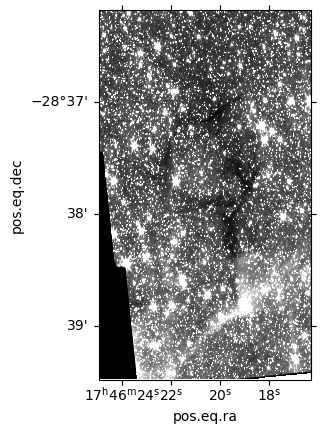

In [10]:
ax = plt.subplot(projection=ww)
ax.imshow(data, origin='lower', cmap='gray', vmin=0, vmax=50)


In [11]:
cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], ww))

# Remove Foreground and Bright Sources

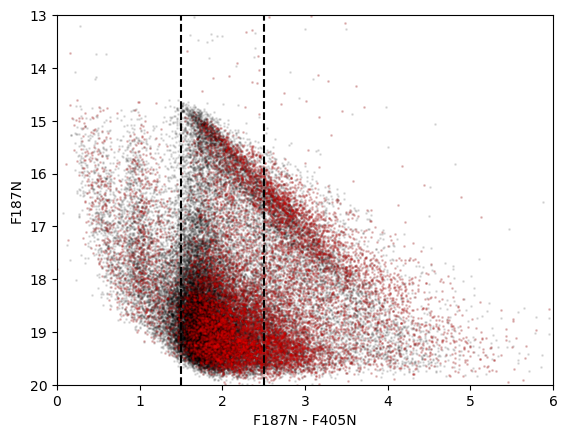

In [12]:
ax = plt.subplot()
cat_use.plot_CMD('f187n', 'f405n', 'f187n', alpha=0.1, s=1, c='k', ax=ax)
cat_filament.plot_CMD('f187n', 'f405n', 'f187n', alpha=0.11, s=1, c='r', ax=ax)
ax.set_xlim(0, 6)
ax.set_ylim(20, 13)
ax.axvline(1.5, color='k', linestyle='--')
ax.axvline(2.5, color='k', linestyle='--')

In [13]:
mask = (cat_filament.catalog['mag_ab_f187n'] > 15 | ~cat_filament.catalog['mag_ab_f187n'].mask)
mask &= cat_filament.catalog['mag_ab_f182m'] > 15 | ~cat_filament.catalog['mag_ab_f182m'].mask
mask &= cat_filament.catalog['mag_ab_f212n'] > 15 | ~cat_filament.catalog['mag_ab_f212n'].mask
mask &= np.logical_or(cat_filament.catalog['mag_ab_f410m'] > 13.25, ~cat_filament.catalog['mag_ab_f410m'].mask)
mask &= np.logical_or(cat_filament.catalog['mag_ab_f466n'] > 13.25, ~cat_filament.catalog['mag_ab_f466n'].mask)
mask &= np.logical_or(cat_filament.catalog['mag_ab_f405n'] > 13.25, ~cat_filament.catalog['mag_ab_f405n'].mask)
mask &= cat_filament.color('f187n', 'f405n') > 2#1.5
masked_cat = JWSTCatalog(cat_filament.apply_mask(mask))

(-2.5, 1.5)

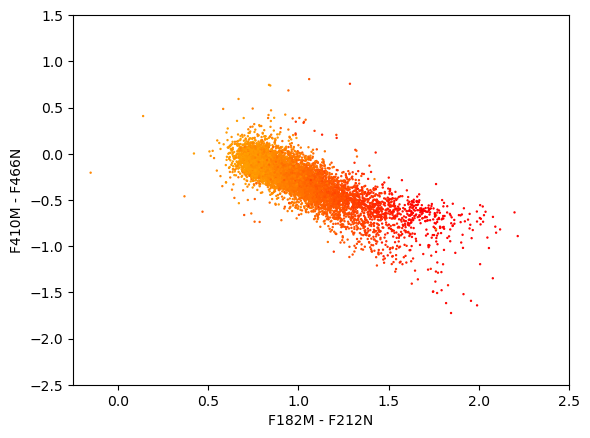

In [14]:
ax2 = plt.subplot(111)
masked_cat.plot_CCD('F182M', 'F212N', 'F410M', 'F466N', c=masked_cat.color('f187n', 'f405n'), ax=ax2, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
ax2.set_xlim(-0.25, 2.5)
ax2.set_ylim(-2.5, 1.5)
#ax2.legend()

# Making Grid

In [15]:
size = (w, l)
bins_ra = np.arange(0, size[1].to(u.arcsec).value, 1)
bins_dec = np.arange(0, size[0].to(u.arcsec).value, 1)

bins_pix_ra = bins_ra/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value
bins_pix_dec = bins_dec/ww.proj_plane_pixel_scales()[0].to(u.arcsec).value

In [16]:
crds_pix = ww.all_world2pix(masked_cat.ra, masked_cat.dec, 0)

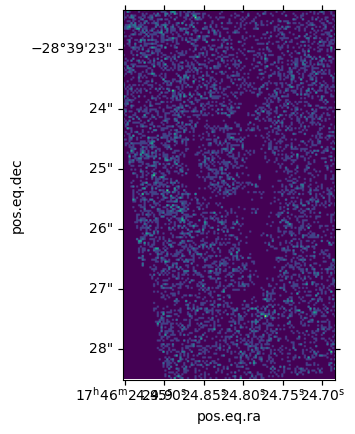

In [17]:
h, xedges, yedges = np.histogram2d(crds_pix[0], crds_pix[1], bins=[bins_pix_ra, bins_pix_dec])
ax = plt.subplot(111, projection=ww)
ax.imshow(h.swapaxes(0,1))

In [18]:
ext_cat = Table()
ext_cat['ra'] = masked_cat.ra
ext_cat['dec'] = masked_cat.dec
ext_cat['x'] = crds_pix[0]
ext_cat['y'] = crds_pix[1]
ext_cat['Av'] = masked_cat.get_Av_182410()
ext_cat['skycoord'] = masked_cat.catalog['skycoord_ref']
ext_cat['mag_ab_f187n'] = masked_cat.catalog['mag_ab_f187n']
ext_cat['mag_ab_f182m'] = masked_cat.catalog['mag_ab_f182m']
ext_cat['mag_ab_f212n'] = masked_cat.catalog['mag_ab_f212n']
ext_cat['mag_ab_f410m'] = masked_cat.catalog['mag_ab_f410m']
ext_cat['mag_ab_f466n'] = masked_cat.catalog['mag_ab_f466n']
ext_cat['mag_ab_f405n'] = masked_cat.catalog['mag_ab_f405n']

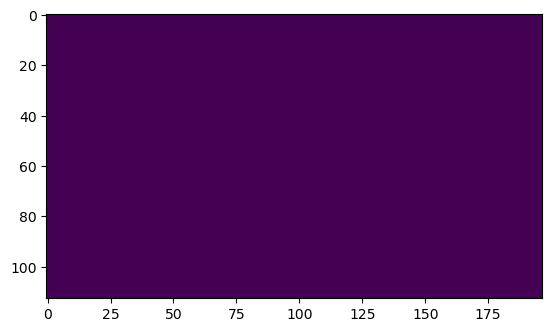

In [19]:
h_0 = np.zeros_like(h)
plt.imshow(h_0)

In [20]:
naxis1 = h_0.shape[0]
naxis2 = h_0.shape[1]

for i in range(naxis1):
    for j in range(naxis2):
        x = bins_pix_ra[i]+0.5
        y = bins_pix_dec[j]+0.5

        ra, dec = ww.wcs_pix2world(x, y, 0)

        pos = SkyCoord(ra, dec, unit=(u.deg, u.deg))

        seplimit = 1.5*u.arcsec
        idx = np.where(pos.separation(ext_cat['skycoord']) < seplimit)[0]

        nearest_stars = ext_cat[idx]

        avg_Av = np.mean(nearest_stars['Av'])

        h_0[i, j] = avg_Av

/scratch/local/45159197/ipykernel_2846081/3188155118.py:20: UserWarning: Warning: converting a masked element to nan.
  h_0[i, j] = avg_Av


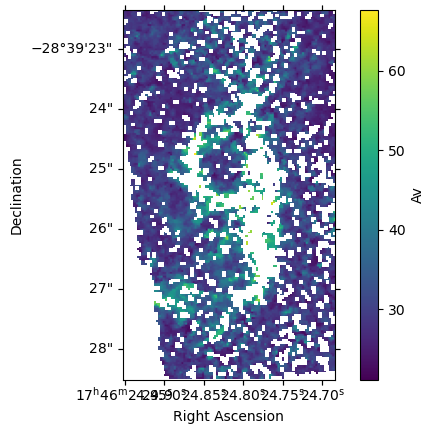

In [21]:
ax = plt.subplot(111, projection=ww)
im = ax.imshow(h_0.swapaxes(0,1))
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

plt.colorbar(im, label='Av', ax=ax)

In [48]:
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel

# Create a Gaussian kernel
gauss_kernel = Gaussian2DKernel(1)

# Interpolate the NaN values
h_1 = interpolate_replace_nans(h_0, gauss_kernel)

# swap axes
h_1 = h_1.swapaxes(0,1)

# Calculate Column Density
N = h_1 * 0.2

In [49]:
from scipy.ndimage import zoom

# Calculate the scaling factors
scale_factor_x = ww.array_shape[1] / h_1.shape[1]
scale_factor_y = ww.array_shape[0] / h_1.shape[0]

# Scale up h_1
h_1_scaled = zoom(h_1, (scale_factor_y, scale_factor_x), order=1)  # Using bilinear interpolation (order=1)

# Scale up N
N_scaled = zoom(N, (scale_factor_y, scale_factor_x), order=1)  # Using bilinear interpolation (order=1)

# Verify the new shape
print(h_1_scaled.shape)

(6339, 3643)


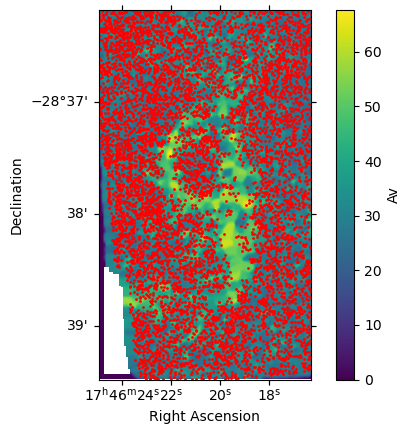

In [24]:
ax = plt.subplot(111, projection=ww)
im = ax.imshow(h_1_scaled, origin='lower')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.colorbar(im, label='Av', ax=ax)
ax.scatter(ext_cat['x'], ext_cat['y'], c='r', s=1)

In [26]:
plt.style.use('dark_background')

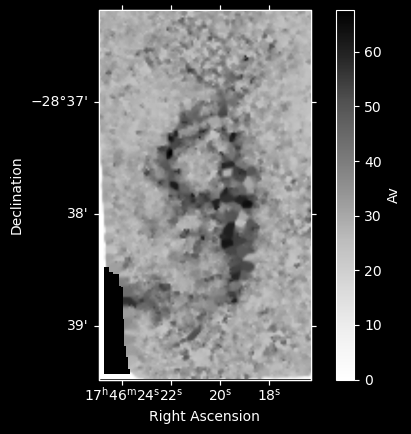

In [50]:
ax = plt.subplot(111, projection=ww)
im = ax.imshow(h_1_scaled, origin='lower', cmap='Greys')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.colorbar(im, label='Av', ax=ax)
#ax.scatter(ext_cat['x'], ext_cat['y'], c='r', s=1)

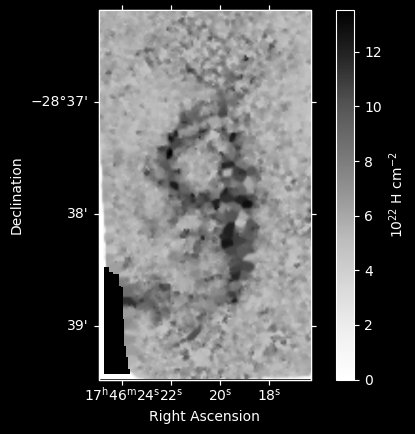

In [51]:
ax = plt.subplot(111, projection=ww)
im = ax.imshow(N_scaled, origin='lower', cmap='Greys')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.colorbar(im, label=r'10$^{22}$ H cm$^{-2}$', ax=ax)
#ax.scatter(ext_cat['x'], ext_cat['y'], c='r', s=1)

In [25]:
ext_cat['Av_measured'] = np.nan
for i in range(len(ext_cat)):
    x, y = ext_cat['x'][i], ext_cat['y'][i]
    x = int(x)
    y = int(y)
    ext_cat['Av_measured'][i] = h_1_scaled[y, x]

In [53]:
ext_cat

ra,dec,x,y,Av,skycoord,mag_ab_f187n,mag_ab_f182m,mag_ab_f212n,mag_ab_f410m,mag_ab_f466n,mag_ab_f405n,Av_measured
deg,deg,,,,"deg,deg",,,,,,,
float64,float64,float64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64,float64
266.6032475263581,-28.603743708232592,71.57515691442609,6242.896064199678,26.224123636548526,"266.6032475263581,-28.603743708232592",19.27414519961452,19.439306840716075,18.653474629783645,17.021723630205013,17.071887550937774,16.98584289764475,25.56829809667931
266.6028100809035,-28.607831632980137,115.89738206794891,5771.773088063528,37.26561686344581,"266.6028100809035,-28.607831632980137",17.5718785252229,17.83997845610888,16.617095589545094,14.40448787853845,14.8515979174474,14.253229694716154,31.673721655074417
266.6027563658287,-28.608466155529275,121.34153249513861,5698.645771830583,30.629185843629934,"266.6027563658287,-28.608466155529275",16.56222350515731,16.779638218603246,15.788349893095981,13.955955472386272,14.21596454075206,13.826535586584683,30.068485244554132
266.60319369666445,-28.604134497426564,77.02770351523827,6197.858766256963,25.079881505226165,"266.60319369666445,-28.604134497426564",19.51355502133299,19.664356262350324,18.938327447060598,17.35225991591082,17.238104529833393,17.331992609820688,28.52289974106716
266.60310890176356,-28.60495001414533,85.61971468786282,6103.872506880089,31.044855045430307,"266.60310890176356,-28.60495001414533",17.600990236176912,17.790406654675152,16.816509756519434,14.928403661904788,15.213026432483963,14.848620046582486,29.248226099034156
266.6027648673514,-28.6081252226168,120.47635557050648,5737.937796894819,31.474539646739355,"266.6027648673514,-28.6081252226168",19.197346874206065,19.40197414632349,18.35843289689594,16.500358837338595,16.627527588137866,16.40346335450295,30.905188071242584
266.6029936956481,-28.60574460659813,97.2883177794788,6012.298137310553,27.350360627578244,"266.6029936956481,-28.60574460659813",19.524189185772165,19.697714846584034,18.786588201950792,17.176304653013176,17.33503834305939,17.01594351548334,28.104252182261654
266.60300334672377,-28.6055803737722,96.3093627408307,6031.225658832465,29.016616214443644,"266.60300334672377,-28.6055803737722",19.01459190495607,19.17342900590718,18.248892412181185,16.498407900984006,16.545582603502652,16.412782791008944,28.634223301775286


In [55]:
ext_cat['skycoord_ref'] = ext_cat['skycoord']
tabl_cat = JWSTCatalog(ext_cat)